In [1]:
# Import libraries
import os,cv2
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras import callbacks
from keras import backend as K
K.set_image_data_format('channels_last')  
from sklearn.metrics import classification_report,confusion_matrix
import itertools
from keras.models import Model
# from tensorflow.keras.applications.resnet import ResNet50
# from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.inception_v3 import decode_predictions
from tensorflow.keras.applications.vgg19 import VGG19

Set path for application

In [2]:
data_path = 'D:/Harold/MyDNN/DataSet/Chest_xray_seperate'
data_dir_list = os.listdir(data_path)
print(data_path)

D:/Harold/MyDNN/DataSet/Chest_xray_seperate


Set Image Size and Epocs

In [3]:
img_rows=128
img_cols=128
num_channel=3
num_epoch=300

Define the number of classes

In [4]:
num_classes = 2

img_data_list=[]

In [5]:
def preprocess_input(x):
    x[:, :, :, 0] -= 103.939
    x[:, :, :, 1] -= 116.779
    x[:, :, :, 2] -= 123.68
    # 'RGB'->'BGR'
    x = x[:, :, :, ::-1]
    return x

def data_preperation():
    for dataset in data_dir_list:
        img_list=os.listdir(data_path+'/'+ dataset)
        print ('Loading the images of dataset-'+'{}\n'.format(dataset))
        for img in img_list:
            img_path = data_path + '/'+ dataset + '/'+ img 
            img = image.load_img(img_path, target_size=(224, 224))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
#             print('Input image shape:', x.shape)
            img_data_list.append(x)
        print('Loading Complete')
        
#     for dataset in data_dir_list:
#         img_list=os.listdir(data_path+'/'+ dataset)
#         print ('Loading the images of dataset-'+'{}\n'.format(dataset))
#         for img in img_list:
#             img_path = data_path + '/'+ dataset + '/'+ img
#             img = image.load_img(img_path, target_size=(224, 224))
#             x = image.img_to_array(img)
#             x = np.expand_dims(x, axis=0)
#             x = preprocess_input(x)
# #             print('Input image shape:', x.shape)
#             img_data_list.append(x)
#         print('Loading Complete')

def display_loss_accuracy(hist):
    train_loss=hist.history['loss']
    val_loss=hist.history['val_loss']
    train_acc=hist.history['accuracy']
    val_acc=hist.history['val_accuracy']
    xc=range(num_epoch)

    plt.figure(1,figsize=(7,5))
    plt.plot(xc,train_loss)
    plt.plot(xc,val_loss)
    plt.xlabel('num of Epochs')
    plt.ylabel('loss')
    plt.title('train_loss vs val_loss')
    plt.grid(True)
    plt.legend(['train','val'])
    #print plt.style.available # use bmh, classic,ggplot for big pictures
    plt.style.use(['classic'])

    plt.figure(2,figsize=(7,5))
    plt.plot(xc,train_acc)
    plt.plot(xc,val_acc)
    plt.xlabel('num of Epochs')
    plt.ylabel('accuracy')
    plt.title('train_acc vs val_acc')
    plt.grid(True)
    plt.legend(['train','val'],loc=4)
    #print plt.style.available # use bmh, classic,ggplot for big pictures
    plt.style.use(['classic'])

def get_featuremaps(model, layer_idx, X_batch):
    get_activations = K.function([model.layers[0].input, K.learning_phase()],[model.layers[layer_idx].output,])
    activations = get_activations([X_batch,0])
    return activations

def plot_featuremap_activations(activations):
    print (np.shape(activations))
    feature_maps = activations[0][0]      
    print (np.shape(feature_maps))
    print (feature_maps.shape)

    fig=plt.figure(figsize=(16,16))
    plt.imshow(feature_maps[:,:,filter_num],cmap='gray')
    plt.savefig("featuremaps-layer-{}".format(layer_num) + "-filternum-{}".format(filter_num)+'.jpg')

    num_of_featuremaps=feature_maps.shape[2]
    fig=plt.figure(figsize=(16,16))	
    plt.title("featuremaps-layer-{}".format(layer_num))
    subplot_num=int(np.ceil(np.sqrt(num_of_featuremaps)))
    for i in range(int(num_of_featuremaps)):
        ax = fig.add_subplot(subplot_num, subplot_num, i+1)
        #ax.imshow(output_image[0,:,:,i],interpolation='nearest' ) #to see the first filter
        ax.imshow(feature_maps[:,:,i],cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
    plt.show()
    fig.savefig("featuremaps-layer-{}".format(layer_num) + '.jpg')
    
# Plotting the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Data Preperation

In [6]:
# Calling Data Preperation
data_preperation()

Loading the images of dataset-NORMAL

Loading Complete
Loading the images of dataset-PNEUMONIA

Loading Complete


In [7]:
print (len(img_data_list))
img_data = np.array(img_data_list)
#img_data = img_data.astype('float32')
print (img_data.shape)
img_data=np.rollaxis(img_data,1,0)
print (img_data.shape)
img_data=img_data[0]
print (img_data.shape)

5856
(5856, 1, 224, 224, 3)
(1, 5856, 224, 224, 3)
(5856, 224, 224, 3)


Assiging Labels

In [8]:
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:1582]=0
labels[1583:5856]=1

names = ['normal','pneumonia']

Creating clasas labels to one-hot encoding

In [9]:
# convert class labels to on-hot encoding
Y = np_utils.to_categorical(labels, num_classes)

Split Data set into training and validation set

In [10]:
#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

Model Definition

Training the classifier alone

In [11]:
image_input = Input(shape=(224, 224, 3))
model = VGG19(input_tensor=image_input, include_top=True,weights='imagenet')
model.summary()
output_layer = model(image_input)

# last_layer = model.get_layer('avg_pool').output
x= Flatten(name='flatten')(output_layer)
out = Dense(num_classes, activation='softmax', name='output_layer')(x)
custom_resnet_model = Model(inputs=image_input,outputs= out)
custom_resnet_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
for layer in custom_resnet_model.layers[:-1]:
    layer.trainable = False

custom_resnet_model.layers[-1].trainable

True

In [13]:
custom_resnet_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [14]:
t = time.time()
hist = custom_resnet_model.fit(X_train, y_train, batch_size=32, epochs=num_epoch, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (t - time.time()))
(loss, accuracy) = custom_resnet_model.evaluate(X_test, y_test, batch_size=10, verbose=1)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

Epoch 1/300
147/147 [==============================] - 13s 91ms/step - loss: 0.6473 - accuracy: 0.7126 - val_loss: 0.6041 - val_accuracy: 0.7338
Epoch 2/300
147/147 [==============================] - 12s 82ms/step - loss: 0.5818 - accuracy: 0.7289 - val_loss: 0.5561 - val_accuracy: 0.7338
Epoch 3/300
147/147 [==============================] - 12s 83ms/step - loss: 0.5463 - accuracy: 0.7293 - val_loss: 0.5270 - val_accuracy: 0.7363
Epoch 4/300
147/147 [==============================] - 12s 83ms/step - loss: 0.5232 - accuracy: 0.7310 - val_loss: 0.5056 - val_accuracy: 0.7406
Epoch 5/300
147/147 [==============================] - 12s 83ms/step - loss: 0.5048 - accuracy: 0.7348 - val_loss: 0.4873 - val_accuracy: 0.7398
Epoch 6/300
147/147 [==============================] - 12s 83ms/step - loss: 0.4888 - accuracy: 0.7415 - val_loss: 0.4709 - val_accuracy: 0.7423
Epoch 7/300
147/147 [==============================] - 12s 83ms/step - loss: 0.4744 - accuracy: 0.7464 - val_loss: 0.4562 - val_ac

In [15]:
(loss, accuracy) = custom_resnet_model.evaluate(X_test, y_test, batch_size=10, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

118/118 [==============================] - 4s 31ms/step - loss: 0.1818 - accuracy: 0.9317
[INFO] loss=0.1818, accuracy: 93.1741%


visualizing losses and accuracy 

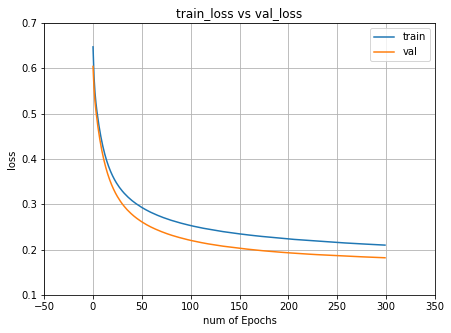

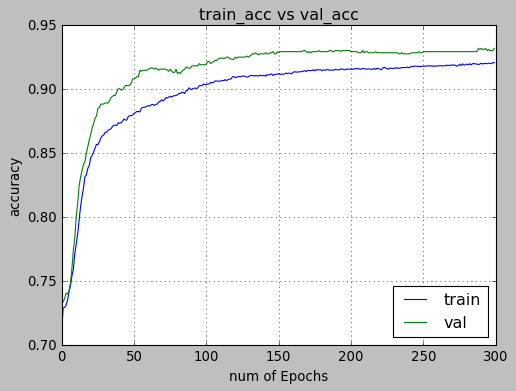

In [16]:
display_loss_accuracy(hist)

# Evaluating the model

In [17]:
score = custom_resnet_model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

test_image = X_test[0:1]
print (test_image.shape)

print(model.predict(test_image))
print(model.predict_classes(test_image))
print(y_test[0:1])

Test Loss: 0.18175366520881653
Test accuracy: 0.9317406415939331
(1, 224, 224, 3)
[[1.60319269e-05 1.03313741e-05 1.10294837e-04 1.62154553e-04
  1.54952664e-04 3.75904006e-06 1.45744079e-05 1.49391735e-06
  7.57235000e-07 9.59678005e-07 2.06255368e-06 4.56184489e-06
  1.86742704e-06 5.95964275e-06 4.45468061e-07 1.67001065e-06
  4.04327830e-06 2.47253524e-06 4.92232402e-06 1.51862960e-05
  6.89771525e-07 1.77929940e-06 2.35125708e-06 7.93170329e-06
  3.36765743e-06 4.09337645e-07 9.40696225e-07 1.42265390e-06
  3.05310095e-06 1.17761365e-05 1.59667673e-06 4.37783820e-06
  1.06327821e-06 8.20454170e-06 9.17864963e-06 9.03331909e-07
  3.70212774e-06 1.50403264e-06 7.12718975e-06 6.36542381e-06
  1.66181053e-05 1.08479242e-06 2.40343957e-06 1.54460020e-06
  2.00442173e-06 2.86294403e-06 1.11290256e-05 2.00422119e-06
  2.27432247e-06 1.55147627e-05 4.49494037e-05 4.17682313e-05
  5.78564004e-06 6.57222654e-06 1.30594326e-05 4.42919827e-06
  6.07707670e-06 1.76240144e-06 3.19003698e-06 3.8

AttributeError: 'Functional' object has no attribute 'predict_classes'

Testing a new image

In [18]:
test_image_path = 'D:/Harold/MyDNN/DataSet/Chest_xray_seperate/PNEUMONIA/person11_bacteria_45.jpeg'
test_image = image.load_img(test_image_path, target_size=(224, 224))
x = image.img_to_array(test_image)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print (x.shape)    

            
# if num_channel==1:
#     if (K.image_data_format() == 'channels_first'):
#         test_image= np.expand_dims(test_image, axis=0)
#         test_image= np.expand_dims(test_image, axis=0)
#         print (test_image.shape)
#     else:
#         test_image= np.expand_dims(test_image, axis=3) 
#         test_image= np.expand_dims(test_image, axis=0)
#         print (test_image.shape)
# else:
#     if (K.image_data_format() == 'channels_first'):
#         test_image=np.rollaxis(test_image,2,0)
#         test_image= np.expand_dims(test_image, axis=0)
#         print (test_image.shape)
#     else:
#         test_image= np.expand_dims(test_image, axis=0)
#         print (test_image.shape)
        
        
# Predicting the test image
yhat = custom_resnet_model.predict(x)
print(yhat)
# print(custom_resnet_model.predict_classes(x))
label = decode_predictions(yhat)
# retrieve the most likely result, e.g. highest probability
label = label[0][0]

(1, 224, 224, 3)
[[0.00989007 0.99010986]]


ValueError: `decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: (1, 2)

Visualizing the intermediate layer

(1, 2)


IndexError: invalid index to scalar variable.

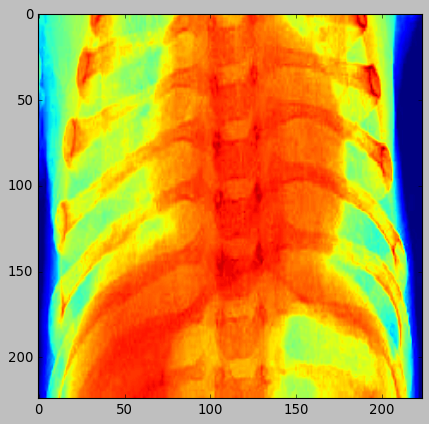

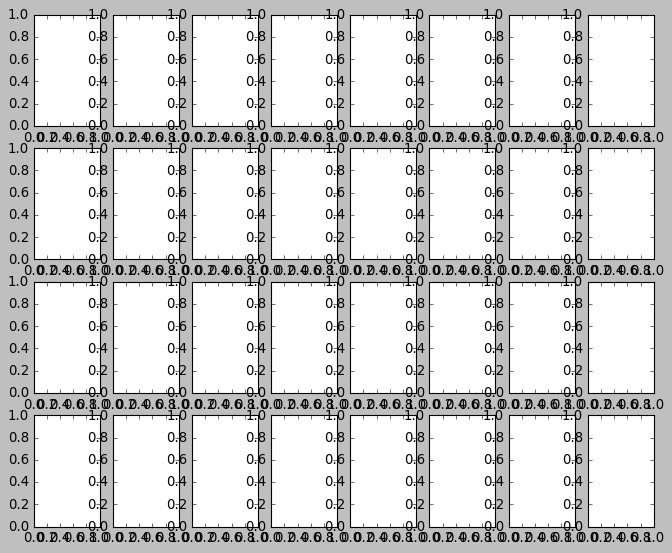

In [19]:
from keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=custom_resnet_model.input, outputs=layer_outputs)
activations = custom_resnet_model.predict(X_train[10].reshape(1,224,224,3))
print(activations.shape)
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[0, act_index]
    activation_index=1
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1
plt.imshow(test_image)
plt.imshow(X_train[10][:,:,0]);
display_activation(activations, 8, 4, 1)

Confusion matrix

In [20]:
Y_pred = custom_resnet_model.predict(X_test)
print(Y_pred)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)
#y_pred = model.predict_classes(X_test)
#print(y_pred)
target_names = ['class 0(Normal)', 'class 1(Pneumonia)']
print(classification_report(np.argmax(y_test,axis=1), y_pred,target_names=target_names))
print(confusion_matrix(np.argmax(y_test,axis=1), y_pred))

[[2.9189095e-03 9.9708110e-01]
 [9.2171538e-01 7.8284606e-02]
 [2.0874552e-01 7.9125452e-01]
 ...
 [1.2248473e-02 9.8775148e-01]
 [2.0469986e-04 9.9979538e-01]
 [9.9027526e-01 9.7247045e-03]]
[1 0 1 ... 1 1 0]
                    precision    recall  f1-score   support

   class 0(Normal)       0.89      0.85      0.87       312
class 1(Pneumonia)       0.95      0.96      0.95       860

          accuracy                           0.93      1172
         macro avg       0.92      0.91      0.91      1172
      weighted avg       0.93      0.93      0.93      1172

[[265  47]
 [ 33 827]]


Compute confusion matrix

Confusion matrix, without normalization
[[265  47]
 [ 33 827]]


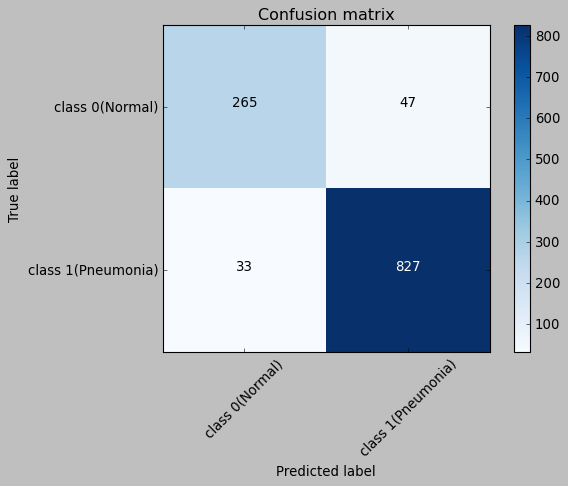

In [21]:
# Compute confusion matrix
cnf_matrix = (confusion_matrix(np.argmax(y_test,axis=1), y_pred))

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix')